**Model NLP untuk Klasifikasi Teks BBC Articles Fulltext and Category**

Dataset: https://www.kaggle.com/datasets/yufengdev/bbc-fulltext-and-category

# **Import Library**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import csv
import nltk
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
%matplotlib inline

print(tf.__version__)

2.15.0


# **Mengunduh Dataset BBC Articles Fulltext and Category**

In [2]:
!pip install -q kaggle

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fauzanbyu","key":"6315917ff5833a191af787ea7c399e2b"}'}

In [4]:
# Membuat direktori dataset pada default direktori '/content'
!mkdir BBCCategory
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d yufengdev/bbc-fulltext-and-category -p /content/BBCCategory/

  0% 0.00/1.83M [00:00<?, ?B/s]
100% 1.83M/1.83M [00:00<00:00, 149MB/s]


In [5]:
!unzip '/content/BBCCategory/bbc-fulltext-and-category.zip' -d /content/BBCCategory/

Archive:  /content/BBCCategory/bbc-fulltext-and-category.zip
  inflating: /content/BBCCategory/bbc-text.csv  


**Mengunduh dan Menyiapkan Stopwords untuk Bahasa Inggris menggunakan NLTK**

In [6]:
# Mengunduh data stopwords untuk bahasa Inggris dari NLTK
nltk.download('stopwords')

# Mendapatkan daftar stopwords bahasa Inggris dan menyimpannya dalam variabel 'stopwords'
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Mengatur path ke file CSV yang berisi data kategori teks BBC
path_csv = '/content/BBCCategory/bbc-text.csv'

# Menampilkan lima baris pertama dari DataFrame untuk melihat struktur data
df = pd.read_csv(path_csv)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [8]:
# Menampilkan informasi DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


Diketahui terdapat 2 kolom dengan tipe data object

# **One-Hot Encoding Representation**

Melakukan one-hot encoding pada kolom kategori untuk representasi biner dan menggabungkan dengan DataFrame asli

In [9]:
kategori = pd.get_dummies(df.category)
df_baru = pd.concat([df, kategori], axis=1)
df_baru = df_baru.drop(columns='category')
df_baru

,text,business,entertainment,politics,sport,tech
0,tv future in the hands of viewers with home th...,0,0,0,0,1
1,worldcom boss left books alone former worldc...,1,0,0,0,0
2,tigers wary of farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle in fa cup premiership s...,0,0,0,1,0
4,ocean s twelve raids box office ocean s twelve...,0,1,0,0,0
...,...,...,...,...,...,...
2220,cars pull down us retail figures us retail sal...,1,0,0,0,0
2221,kilroy unveils immigration policy ex-chatshow ...,0,0,1,0,0
2222,rem announce new glasgow concert us band rem h...,0,1,0,0,0
2223,how political squabbles snowball it s become c...,0,0,1,0,0


# **Data Preparation**

In [10]:
# Mengubah nilai-nilai dari DataFrame ke dalam tipe data numpy array
bbc_text = df_baru['text'].values
label = df_baru[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [11]:
# Membagi data menjadi training dan test set dengan rasio 80:20
bbc_text_train, bbc_text_test, label_train, label_test = train_test_split(bbc_text, label, test_size=0.2)

In [12]:
# Inisialisasi list untuk menyimpan data BBC dan label terkait
bbc_datas = []
labels = []

# Memuat file CSV untuk membaca data BBC dan label terkait
with open(path_csv, 'r') as file_csv:
    read = csv.reader(file_csv)
    next(read)  # Mengabaikan baris header

    # Iterasi melalui setiap baris data dalam file CSV
    for row in read:
        bbc_data = row[1]
        labels.append(row[0])

        # Membersihkan data teks dari stopwords
        for word in stopwords:
            token = ' ' + word + ' '
            bbc_data = bbc_data.replace(' ', ' ')
            bbc_data = bbc_data.replace(token, ' ')
            bbc_data = bbc_data.replace(token, token)

        # Menambahkan data yang telah dibersihkan ke dalam list
        bbc_datas.append(bbc_data)

In [13]:
# Inisialisasi Tokenizer dan melakukan fitting pada teks BBC
tokenizer = Tokenizer()
tokenizer.fit_on_texts(bbc_datas)

# Mendapatkan indeks-kata dari tokenizer
index_word = tokenizer.index_word
num_words = 5000
num_words = len(index_word)

# Mengonversi teks BBC ke dalam sekuens angka menggunakan tokenizer
sekuens = tokenizer.texts_to_sequences(bbc_datas)

# Melakukan padding pada sekuens agar memiliki panjang maksimal 200
padded = pad_sequences(sekuens, maxlen=200, padding='post', truncating='post')

In [14]:
# Menentukan ukuran data pelatihan (80% dari total data)
train_size = int(len(bbc_datas) * 0.8)

# Mengambil sekuens dan label untuk data pelatihan
train_sequences = padded[0:train_size]
train_labels = labels[0:train_size]

# Mengambil sekuens dan label untuk data validasi
val_sequences = padded[train_size:]
val_labels = labels[train_size:]

In [15]:
# Inisialisasi Tokenizer untuk label dan fitting pada label data pelatihan
tokenizer_labels = Tokenizer()
tokenizer_labels.fit_on_texts(labels)

# Mengonversi label data pelatihan dan validasi ke dalam sekuens angka menggunakan tokenizer label
train_label_sequences = np.array(tokenizer_labels.texts_to_sequences(train_labels))
val_label_sequences = np.array(tokenizer_labels.texts_to_sequences(val_labels))

In [16]:
# Membuat arsitektur model Sequential, LSTM, dan Embedding
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words+1, 100, input_length=200, trainable=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          2969900   
                                                                 
 dropout (Dropout)           (None, 200, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 196, 64)           32064     
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [17]:
# Compile model dengan RMSprop optimizer loss function 'sparse_categorical_crossentropy'
model.compile(optimizer='RMSprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# Penggunaan callback untuk stop pelatihan ketika accuracy > 0.80
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.80) & (logs.get('val_accuracy') > 0.80):
      print('\n')
      print('Reached %2.2f%% accuracy, stopping training...' %(0.80 * 100))
      print('\n')
      self.model.stop_training = True

callbacks = Callback()

num_epochs = 50

# Pelatihan model dengan model.fit
hist = model.fit(
    train_sequences,
    train_label_sequences,
    epochs=num_epochs,
    validation_data=(val_sequences, val_label_sequences),
    verbose=2,
    callbacks=[callbacks])

Epoch 1/50
56/56 - 8s - loss: 1.6015 - accuracy: 0.2646 - val_loss: 1.5328 - val_accuracy: 0.2876 - 8s/epoch - 144ms/step
Epoch 2/50
56/56 - 6s - loss: 1.5346 - accuracy: 0.2888 - val_loss: 1.5146 - val_accuracy: 0.3213 - 6s/epoch - 111ms/step
Epoch 3/50
56/56 - 6s - loss: 1.5294 - accuracy: 0.2983 - val_loss: 1.4890 - val_accuracy: 0.3483 - 6s/epoch - 114ms/step
Epoch 4/50
56/56 - 7s - loss: 1.5209 - accuracy: 0.2983 - val_loss: 1.4827 - val_accuracy: 0.3618 - 7s/epoch - 121ms/step
Epoch 5/50
56/56 - 5s - loss: 1.4944 - accuracy: 0.3163 - val_loss: 1.4052 - val_accuracy: 0.3978 - 5s/epoch - 95ms/step
Epoch 6/50
56/56 - 3s - loss: 1.4308 - accuracy: 0.3612 - val_loss: 1.4281 - val_accuracy: 0.3416 - 3s/epoch - 54ms/step
Epoch 7/50
56/56 - 3s - loss: 1.3819 - accuracy: 0.3848 - val_loss: 1.2913 - val_accuracy: 0.4225 - 3s/epoch - 54ms/step
Epoch 8/50
56/56 - 4s - loss: 1.3426 - accuracy: 0.3882 - val_loss: 1.2792 - val_accuracy: 0.4787 - 4s/epoch - 76ms/step
Epoch 9/50
56/56 - 3s - loss

# **Plot Accuracy dan Loss**

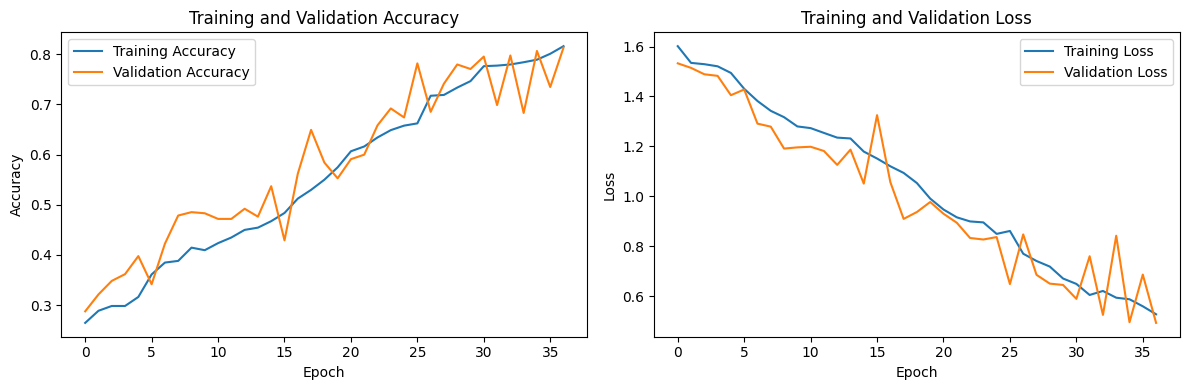

In [21]:
# Menampilkan plot training dan validasi accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Menampilkan plot training dan validasi loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

Berdasarkan hasil plot akurasi dan loss model, akurasi pelatihan dan validasi meningkat secara signifikan, mencapai nilai target 80% pada epoch ke-35. Sementara itu loss pelatihan dan validasi juga menurun secara signifikan.

Selain itu gap antara kurva akurasi pelatihan dan validasi cukup kecil, yaitu sekitar 1%. Hal ini menunjukkan bahwa model tidak mengalami overfitting yang signifikan.

Secara keseluruhan, model NLP yang dilatih memiliki kinerja yang baik. Namun, masih ada potensi untuk meningkatkan akurasi dengan menggunakan lebih banyak data pelatihan atau dengan penyesuaian model.